# Growing Grid

In [2]:
from nilearn import plotting
from nilearn.image import index_img, load_img
import numpy as np
from collections import deque

In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

In [4]:
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [5]:
class SOM(nn.Module):
    """
    3-D Growing Grid (extension of Kohonen Self-Organizing Map) with Gaussian neighbourhood function
    and exponentially decreasing learning rate. 
    For a description of 2-D model see: 'Growing Grid - a self-organizing network with constant
    neighborhood range and adaptation strength', B. Fritzke, 1995, doi:10.1007/BF02332159
    """
    #constants for hexagonal grid generation
    #hexagonal close-packed (HCP) structure c/a ratio equals sqrt(8/3)
    Z_RATIO = np.sqrt(8/3)/2
    Y_RATIO = np.sqrt(3)/2
    X_RATIO = 0.5
    SHIFT = np.sqrt(3)/3
    
    def __init__(self, m, n, p, dim, niter, alpha=None, sigma=None, lambda_g=30, topology='rectangular'):
        super(SOM, self).__init__()
        #number of nodes in x direction
        self.m = m
        #number of nodes in y direction
        self.n = n
        #number of nodes in z direction
        self.p = p
        #input dimensionality
        self.dim = dim
        #number of passes through dataset
        self.niter = niter
        self.num = m*n*p
        #shape of neighbourhood in grid space
        self.topology = topology
        #parameter that regulates how often new nodes are inserted (lambda_g in Fritzke 1995)
        self.lambda_g = lambda_g
        self.adaptations = self.num*self.lambda_g
        #learning rate
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        #radius of neighbourhood function
        if sigma is None:
            #initially all nodes are withing the range of neighbourhood function
            self.sigma = max(m, n, p) / 2.0
        else:
            self.sigma = float(sigma)

        #grid space
        self.locations = self.neuron_locations()
        #accumulated errors
        self.errors = torch.zeros(self.m, self.n, self.p)
        #feature space
        self.weights = torch.randn([self.m, self.n, self.p, dim], dtype=torch.float)
        self.pdist = nn.PairwiseDistance(p=2)
        print('Initialized with {} nodes, lambda_g {} and {} topology.'.format(self.num, self.lambda_g, self.topology))

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def neuron_locations(self):
        neurons = torch.empty(self.m, self.n, self.p, 3)
        if self.topology == 'rectangular':
            #Build cubic structure of SOM space
            for i in range(self.m):
                for j in range(self.n):
                    for k in range(self.p):
                        neurons[i, j, k] = torch.FloatTensor([i, j, k])
        elif self.topology == 'hexagonal':
            #Build honeycomb structure of SOM space
            for i in range(self.m):
                for j in range(self.n):
                    for k in range(self.p):
                        xval = np.ceil(i*1.5)
                        yval = j*self.Y_RATIO + (self.SHIFT*k)
                        if not j%2:
                            if i%2:
                                xval -= self.X_RATIO
                            else:
                                xval += self.X_RATIO
                        neurons[i, j, k] = torch.FloatTensor([xval, yval, k*self.Z_RATIO])
                
        return neurons
    
    def find_neighbours_idx(self, x):
        """
        :param x: tensor from grid space
        output: tensor of indices of it's closest neighbours in grid space
        (e.g up to 6 in rectangular topoplogy, differing in dimension x, y or z exactly by 1)
        constants:
            radius - nodes that lie in grid space closer to x than radius
            are considered neighbours of x
        """
        radius = 2
        absolute = torch.abs(self.locations-x)
        if self.topology == 'hexagonal':
            #this value just works well for visualization
            radius = 1.4
        sums = torch.sum(absolute.view(-1, 3), 1)
        idx = ((sums<radius) & (sums>0.01)).nonzero().squeeze()
        return idx
        
    def find_neighbours_rectangular(self, x):
        """
        input: tensor from grid space
        output: 2-d tensor of it's (up to 6) closest neighbours
        differing in dimension x, y or z exactly by 1
        info: only works in rectangular topology
        """
        neighbours = torch.stack((x, x, x, x, x, x))
        neighbours.add_(torch.cat((torch.eye(3, dtype=torch.long), torch.neg(torch.eye(3, dtype=torch.long)))))
        indices = []
        for i, y in enumerate(neighbours):
            if torch.min(y) >= 0 and y[0] < self.m and y[1] < self.n and y[2] < self.p:
                indices.append(i)
        return torch.index_select(neighbours, 0, torch.tensor(indices))
    
    def find_direction_hexagonal(self):
        x_avg = self.errors.sum(2).sum(1)
        #concatenate odd and even rows in y direction
        y_avg = self.errors.sum(2).sum(0).view(-1, 2).sum(1)
        z_avg = self.errors.sum(1).sum(0)
        x_max, x_idx = torch.max(x_avg, 0)
        y_max, y_idx = torch.max(y_avg, 0)
        z_max, z_idx = torch.max(z_avg, 0)
        directions = ['x', 'y', 'z']
        #plane with the highest mean error gives index and direction in which new layer will be inserted
        direction = torch.argmax(torch.tensor([x_max, y_max, z_max]))
        idx = [x_idx, y_idx, z_idx][direction]
        bound = [self.m, self.n, self.p][direction]
        #Calculate whether to insert a new plane above or below given index
        if direction == 0:
            if (idx == 0):
                return directions[direction], idx
            elif (idx == bound-1):
                return directions[direction], idx-1
            else:
                down = self.pdist(self.weights[idx, :, :].view(-1, 1), self.weights[idx-1, :, :].view(-1, 1))
                up = self.pdist(self.weights[idx, :, :].view(-1, 1), self.weights[idx+1, :, :].view(-1, 1))
        elif direction == 1:
            if (idx <= 1):
                return directions[direction], 1
            elif (idx >= bound-2):
                return directions[direction], bound-2
            elif(idx%2):
                down = self.pdist(torch.cat((self.weights[:, idx, :], self.weights[:, idx-1, :])).view(-1, 1),
                                 torch.cat((self.weights[:, idx-2, :], self.weights[:, idx-3])).view(-1, 1))
                up = self.pdist(torch.cat((self.weights[:, idx-1, :], self.weights[:, idx, :])).view(-1, 1),
                                 torch.cat((self.weights[:, idx+1, :], self.weights[:, idx+2])).view(-1, 1))
            else:
                #not idx%2
                down = self.pdist(torch.cat((self.weights[:, idx+1, :], self.weights[:, idx, :])).view(-1, 1),
                                 torch.cat((self.weights[:, idx-1, :], self.weights[:, idx-2])).view(-1, 1))
                up = self.pdist(torch.cat((self.weights[:, idx, :], self.weights[:, idx+1, :])).view(-1, 1),
                                 torch.cat((self.weights[:, idx+2, :], self.weights[:, idx+3])).view(-1, 1))
        else:
            #direction == 2
            if (idx == 0):
                return directions[direction], idx
            elif (idx == bound-1):
                return directions[direction], idx-1
            down = self.pdist(self.weights[:, :, idx].view(-1, 1), self.weights[:, :, idx-1].view(-1, 1))
            up = self.pdist(self.weights[:, :, idx].view(-1, 1), self.weights[:, :, idx+1].view(-1, 1))
            
        #Return lower index of two found planes
        if torch.mean(down) > torch.mean(up):
            #In y direction corresponding planes are 2 indices apart
            if direction == 1:
                idx -= 2
            else:
                idx -= 1
        return directions[direction], idx
        
                    
    def find_direction(self):
        """
        input: tensor from grid space
        output: a tuple (direction, level)
            direction ('x', 'y' or 'z') in which new som layer should be inserted
            level (-1, 1) indicates whether new plane should be inserted below (-1) or above (1)
            the plane of input tensor
        info: output is calculated by finding a neighbouring node in grid space
        that has the most distant position in feature space
        """
        if self.topology == 'hexagonal':
            return self.find_direction_hexagonal()
        
        #q-unit from Fritzke 1995: node with most accumulated errors
        qunit_idx = torch.argmax(self.errors)
        #q-unit location in grid space
        x_loc = self.locations.view(-1, 3)[qunit_idx]
        #q-unit weight in feature space
        x_weight = self.weights.view(-1, self.dim)[qunit_idx]
        directions = ['x', 'y', 'z']
        #indices of immediate q-unit neighbouring nodes in grid space
        neigh_idx = self.find_neighbours_idx(x_loc)
        #locations of immediate q-unit neighbouring nodes in grid space
        neigh = self.locations.view(-1, 3)[neigh_idx]
        #weights of immediate q-unit neighbouring nodes in feature space
        neigh_weights = self.weights.view(-1, self.dim)[neigh_idx]
        #euclidean distances in feature space between q-unit and its neighbours
        dists = self.pdist(x_weight, neigh_weights)
        #index of the node most distant to q-unit in feature space
        max_idx = torch.argmax(dists)
        #orignal location of the farthest neighbour within grid space (self.locations)
        farthest = torch.LongTensor(np.unravel_index(neigh_idx[max_idx], self.locations.size()[:3]))
        #orignal location of the q-unit within grid space (self.locations)
        x_real = torch.LongTensor(np.unravel_index(qunit_idx, self.locations.size()[:3]))
        
        #find dimension in which the farthest node and q-unit differ
        diff = farthest.add(torch.neg(x_real)).flatten()
        #find whether the farthest node is below or above q-unit in grid space
        level = torch.sum(diff)
        direction = torch.nonzero(diff)
        
        #return lower index of two found nodes
        if level > self.Z_RATIO - 0.1:
            change = 0
        elif level < -self.Z_RATIO - 0.1:
            change = -1
        else:
            print('Expected index level -1 or 1, got: {}'.format(level))
            return
        
        return directions[direction], x_real[direction] + change
    
    def add_layer(self):
        direction, idx = self.find_direction()
        print('Inserting layer in {} direction'.format(direction))
        if direction == 'x':
            if self.topology == 'rectangular':
                new_plane = torch.div(torch.sum(self.weights[idx:idx+2, :, :],0,keepdim=True), 2.)
                first_half = self.weights[0:idx+1, :, :]
                second_half = self.weights[idx+1:, :, :]
                #Insert into weights averages of vectors surrounding vectors in new plane
                self.weights = torch.cat((first_half, new_plane, second_half),0)
                #Append to locations last plane, incremented by one
                self.locations = torch.cat((self.locations,
                                (self.locations[self.m-1, :, :, :]+torch.FloatTensor([1, 0, 0])).unsqueeze(0)), 0)
                self.m += 1
            elif self.topology == 'hexagonal':
                leftmost_plane = torch.sum(
                    torch.stack((0.75*self.weights[idx, :, :, :], 0.25*self.weights[idx+1, :, :, :])),0,keepdim=True)
                leftmid_plane = torch.sum(
                    torch.stack((0.6*self.weights[idx, :, :, :], 0.4*self.weights[idx+1, :, :, :])),0,keepdim=True)
                rightmost_plane = torch.sum(
                    torch.stack((0.25*self.weights[idx, :, :, :], 0.75*self.weights[idx+1, :, :, :])),0,keepdim=True)
                rightmid_plane = torch.sum(
                    torch.stack((0.4*self.weights[idx, :, :, :], 0.6*self.weights[idx+1, :, :, :])),0,keepdim=True)
                #start from the outer planes when idx is even, from mid planes otherwise
                parity = torch.ByteTensor([not (idx+x)%2 for x in torch.arange(self.n)]).unsqueeze(1).expand(self.n, self.dim).reshape(self.n, 1, self.dim)
                #choose from leftmost in even positions, from leftmid in odd
                left = torch.where(parity, leftmost_plane,
                leftmid_plane)
                #reduce unnecessary dimensions
                while (left.dim() > 4):
                    left.squeeze_(0)
                #choose from rightmost in even positions, from rightmid in odd
                right = torch.where(parity, rightmost_plane,
                rightmid_plane)
                #reduce unnecessary dimensions
                while(right.dim() > 4):
                    right.squeeze_(0)
                first_half = self.weights[0:idx+1, :, :, :]
                second_half = self.weights[idx+1:, :, :, :]
                ##Insert into weights averages of vectors surrounding vectors in new plane
                self.weights = torch.cat((
                    first_half, left, right, second_half),0)
                self.locations = torch.cat((self.locations,
                                (self.locations[(self.m-2):, :, :, :]+torch.FloatTensor([3, 0, 0]))), 0)
                self.m += 2
                
        elif direction == 'y':
            if self.topology == 'rectangular':
                new_plane = torch.div(torch.sum(self.weights[:, idx:idx+2, :, :],1,keepdim=True), 2.)
                first_half = self.weights[:, 0:idx+1, :, :]
                second_half = self.weights[:, idx+1:, :, :]
                #Insert into weights averages of vectors surrounding vectors in new plane
                self.weights = torch.cat((first_half, new_plane, second_half),1)
                increment = torch.FloatTensor([0, 1, 0])
                #Append to locations last plane, incremented by one
                self.locations = torch.cat((self.locations,
                                (self.locations[:, self.n-1, :, :]+increment).unsqueeze(1)), 1)
                self.n += 1
            elif self.topology == 'hexagonal':
                new_plane_low = torch.div(torch.sum(self.weights[:, [idx-1, idx+1], :, :],1,keepdim=True), 2.)
                new_plane_high = torch.div(torch.sum(self.weights[:, [idx, idx+2], :, :],1,keepdim=True), 2.)
                first_half = self.weights[:, 0:idx+1, :, :]
                second_half = self.weights[:, idx+1:, :, :]
                #Insert into weights averages of vectors surrounding vectors in new plane
                self.weights = torch.cat((first_half, new_plane_low, new_plane_high, second_half),1)
                #Append to locations last two planes, increment
                self.locations = torch.cat((self.locations,
                                (self.locations[:, (self.n-2):, :, :]+torch.FloatTensor([0, 2*self.Y_RATIO, 0]))), 1)
                self.n += 2
        elif direction == 'z':
            new_plane = torch.div(torch.sum(self.weights[:, :, idx:idx+2, :],2,keepdim=True), 2.)
            first_half = self.weights[:, :, 0:idx+1, :]
            second_half = self.weights[:, :, idx+1:, :]
            #Insert into weights averages of vectors surrounding vectors in new plane
            self.weights = torch.cat((first_half, new_plane, second_half), 2)
            if self.topology == 'rectangular':
                increment = torch.FloatTensor([0, 0, 1])
            elif self.topology == 'hexagonal':
                increment = torch.FloatTensor([0, self.SHIFT, self.Z_RATIO])
            #Append to locations last plane, incremented by one
            self.locations = torch.cat((self.locations,
                            (self.locations[:, :, self.p-1, :]+increment).unsqueeze(2)), 2)
            self.p += 1
        else:
            print("Expected direction 'x', 'y', or 'z', got: {}".format(idx))
            return
        self.num = self.m*self.n*self.p
        self.errors.resize_(self.m, self.n, self.p)
        #reset errors
        self.errors.fill_(0)

    def edges(self, space='feature'):
        """
        params:
            space: 'grid' or 'feature' return coordinates in grid or feature space
        output: list of lists (tensor, tensor) all edges between nodes
        info: to be used for visualization; BFS algorithm
        """
        visited = torch.zeros(self.num, dtype = torch.uint8)
        visited[0] = 1
        if space == 'feature':
            data = self.weights
        elif space == 'grid':
            data = self.locations
        queue = deque()
        queue.append(0)
        lines = torch.tensor([])
        while(len(queue)>0):
            vertex = queue.pop()
            visited[vertex] = 2
            neigh = self.find_neighbours_idx(self.locations.view(-1, 3)[vertex])
            #if node has only one neighbour
            if neigh.dim() < 1:
                neigh = neigh.unsqueeze(0)
            for n in neigh:
                if visited[n] < 2:
                    result = torch.stack((data.view(-1, 3)[vertex], data.view(-1, 3)[n]))
                    lines = torch.cat((lines, result.unsqueeze(0)))
                    if not visited[n]:
                        visited[n] = 1
                        queue.append(n)
        return lines
    
    def show_grid(self, space='feature'):
        """
        params:
            space: 'grid' or 'feature' - take nodes locations from 3-D SOM space
            or nodes weights in feature (the same as input) space (possible only for 3-D inputs)
        output: 3-D plot of SOM nodes locations/weights
        """
        if space == 'feature':
            if self.dim != 3:
                print("Feature space visualization is possible only for 3-D inputs")
                return
            nodes = self.weights.view(-1, self.dim)
        elif space == 'grid':
            nodes = self.locations.view(-1, 3)
        else:
            print("Expected space 'grid' or 'feature', got {}".format(space))
            return
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        edges = self.edges(space)
        max_lim = torch.max(edges)
        min_lim = torch.min(edges)
        ax.set_xlim(min_lim, max_lim)
        ax.set_ylim(min_lim, max_lim)
        ax.set_zlim(min_lim, max_lim)
        lc = Line3DCollection(edges, linewidths=0.6, colors='r')
        ax.add_collection(lc)
        ax.scatter(nodes[:,0],nodes[:,1],nodes[:,2], color = 'r', s=3)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    
    def forward(self, x, it):
        """
        Perform learning step.
        """
        
        #Insert layers after reaching number of iterations controlled by lambda_g constant
        #do not insert new layers in the last 1/3 of iterations
        if (self.adaptations < 1 and it < self.niter/1.5):
            self.add_layer()
            self.adaptations = self.num * self.lambda_g
        self.adaptations -= 1
        
        #compute distances between data point and SOM weights
        dists = self.pdist(x, self.weights.view(-1, self.dim))
        #index of Best Matching Unit (BMU)
        bmu_index = torch.argmin(dists)
        #increment accumulated error of BMU
        self.errors.view(-1, 1)[bmu_index] += 1
        #BMU localization in grid space
        bmu_loc = self.locations.view(-1, 3)[bmu_index]
        #compute euclidean distance between data
        bmu_distance_squares = torch.sum(torch.pow(self.locations - bmu_loc.unsqueeze(0), 2), 3)
        
        #decrease learning rate exponentially
        learning_rate_op = np.exp(-it/self.niter)
        #decrease neighbourhood function radius according to learning rate
        sigma_op = self.sigma * learning_rate_op
        #compute neighbourhood function in grid space
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, 2*(sigma_op**2))))
        learning_rate_op = self.alpha*learning_rate_op*neighbourhood_func

        #update weights
        delta = torch.mul(learning_rate_op.unsqueeze(-1), (x.unsqueeze(0) - self.weights))                                         
        self.weights.add_(delta)

In [6]:
scan = load_img("func_data.nii.gz");
img = index_img(scan, 73);
#img = load_img("/home/guzik/Moje/TCS/ML/data/ds000030/ds000030_R1.0.5/derivatives/fmriprep/sub-10159/anat/sub-10159_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz");
raw_data = img.get_fdata()

In [7]:
coor = np.array(np.meshgrid(np.arange(raw_data.shape[0]), np.arange(raw_data.shape[1]), np.arange(raw_data.shape[2]))).T.reshape(-1, 3)
values = raw_data[coor[:,0], coor[:, 1], coor[:, 2]]
indices = values>200
coor_data = np.hstack((coor[indices].reshape(-1, 3), values[indices].reshape(-1, 1)))

In [8]:
m = 2
n = 4
p = 2
unnormalized_data = torch.from_numpy(coor_data).float()
mean = torch.mean(unnormalized_data, 0)
std = torch.std(unnormalized_data, 0)
data = (unnormalized_data-mean)/std

n_iter = 31
som = SOM(m, n, p, 4, n_iter, lambda_g=4000, topology='hexagonal')

Initialized with 16 nodes, lambda_g 4000 and hexagonal topology.


In [10]:
for iter_no in range(n_iter):
    print("Iteration {}".format(iter_no))
    #Train with each vector one by one
    for i in range(len(data)):
        som(data[i], iter_no)

Iteration 0
Inserting layer in z direction
Iteration 1
Iteration 2
Inserting layer in y direction
Iteration 3
Iteration 4
Inserting layer in x direction
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Inserting layer in z direction
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Inserting layer in y direction
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30


In [11]:
def find_bmu(x):
    """
    input: data point from input space
    output: BMU index in SOM space
    """
    dists = som.pdist(torch.tensor(x), som.weights.view(-1, som.dim))
    return torch.argmin(dists) 

In [12]:
if som.num < 128:
    dtype = 'int8'
elif som.num < 32768:
    dtype = 'int16'
elif som.num < 2147483647:
    dtype = 'int32'
else:
    dtype = 'int64'
#Voxels that are ommitted in traing have value 0 (black color)
segmentation = -np.ones(raw_data.shape, dtype=dtype)
#For each voxel find corresponing best matching unit
segmentation[coor[indices][:, 0], coor[indices][:, 1], coor[indices][:, 2]] = np.apply_along_axis(find_bmu, 1, data)
segmentation += 1

In [13]:
#Create array of colors corresponing to SOM units and reserve one color (black) for the background
colors = np.linspace(0,1,som.num+1)
#For better visual separation of brain areas shuffle all colors apart from black
np.random.shuffle(colors[1:])
cmap = plt.cm.colors.ListedColormap(plt.cm.nipy_spectral(colors))

<IPython.core.display.Javascript object>


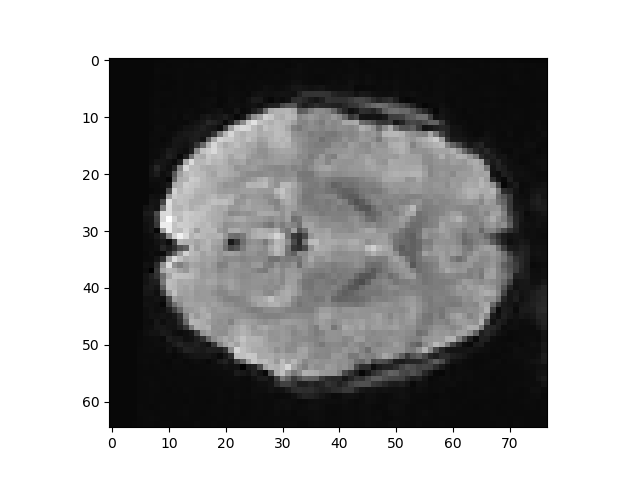

In [14]:
#Plot selected image from original data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(raw_data[:, :, 20], cmap='gray');
plt.show()

<IPython.core.display.Javascript object>


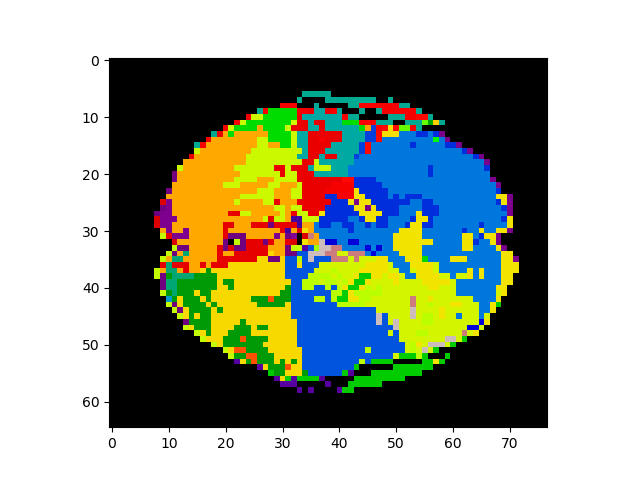

In [15]:
#Plot corresponding image after clustering
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(segmentation[:, :, 20], cmap=cmap);
plt.show()

<IPython.core.display.Javascript object>


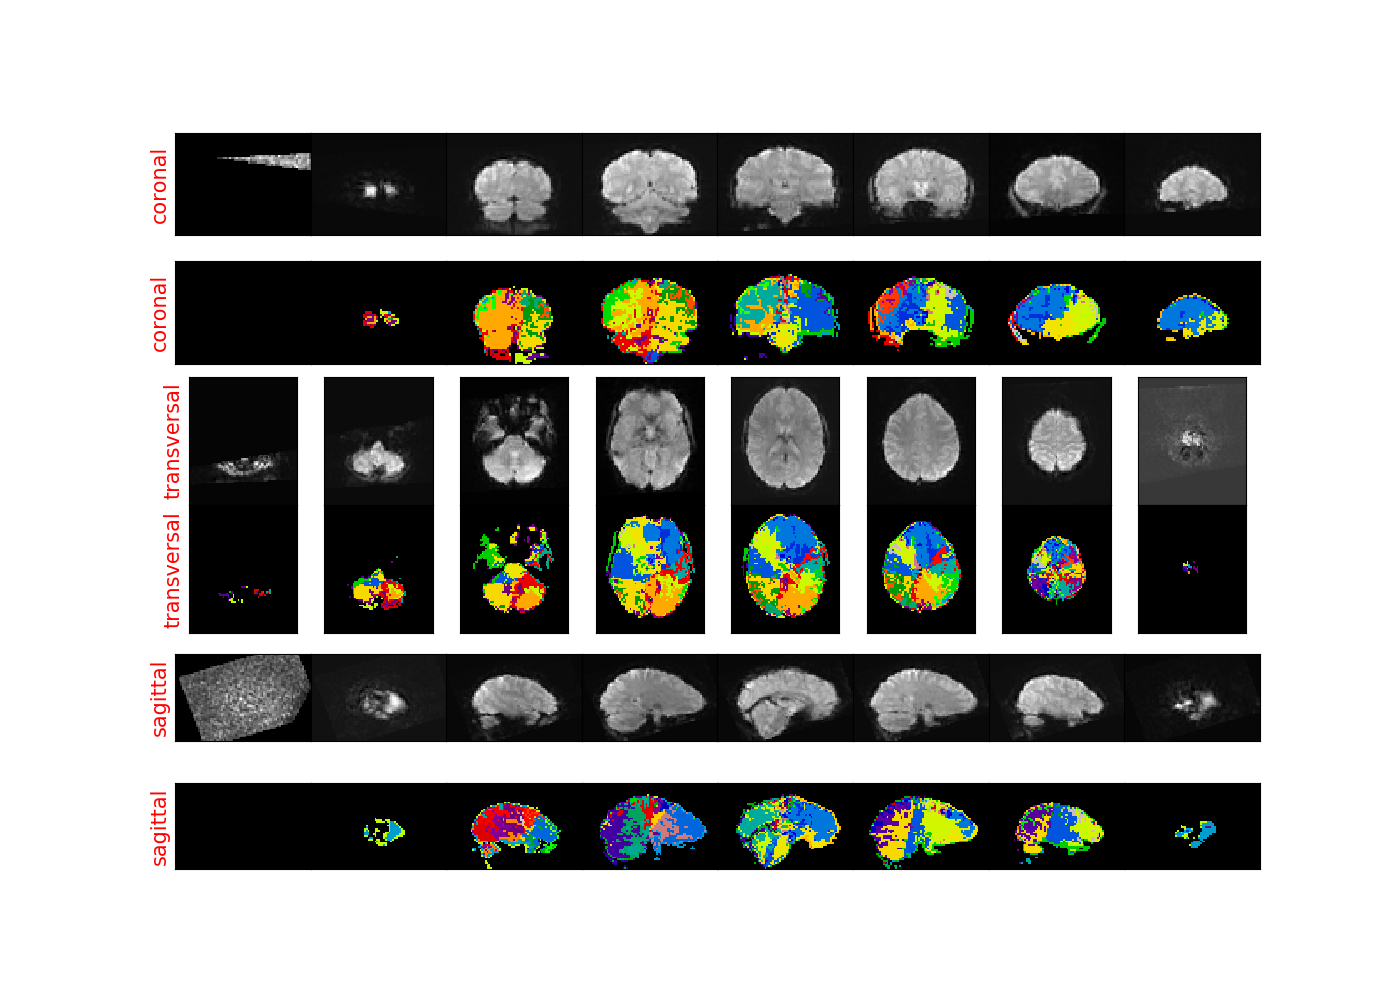

In [16]:
#based on article https://medium.com/coinmonks/visualizing-brain-imaging-data-fmri-with-python-e1d0358d9dba
# Create subplots
fig, ax = plt.subplots(6, 8, figsize=[14, 10])

def plot_slices(ax, pos, data, cmap, plane):
    """
    Plot brain slices in three planes: coronal, transversal and sagittal,
    odd rows (0, 2, 4) correspond to original data
    even rows (1, 3, 5) show the results of clustering
    """
    slice_num = 8
    n = 0
    for i in range(slice_num):
        ax[pos][i].imshow(data[:, :, n], cmap=cmap)
        ax[pos][i].set_xticks([])
        ax[pos][i].set_yticks([])
        if i == 0:
            ax[pos][i].set_ylabel(plane, fontsize=15, color='r')
        n += data.shape[2]//slice_num
        
###RESULTS
# Orgaize the data for visualisation in the coronal plane
coronal = np.transpose(segmentation, [0, 2, 1])
coronal = np.rot90(coronal, 1)

# Orgaize the data for visualisation in the transversal plane
transversal = np.transpose(segmentation, [1, 0, 2])
transversal = np.rot90(transversal, 2)

# Orgaize the data for visualisation in the sagittal plane
sagittal = np.transpose(segmentation, [1, 2, 0])
sagittal = np.rot90(sagittal, 1)

# Plot clustering resutls        
plot_slices(ax, 1, coronal, cmap, 'coronal')
plot_slices(ax, 3, transversal, cmap, 'transversal')
plot_slices(ax, 5, sagittal, cmap, 'sagittal')
    
###ORIGINAL
# Orgaize the data for visualisation in the coronal plane
coronal = np.transpose(raw_data, [0, 2, 1])
coronal = np.rot90(coronal, 1)

# Orgaize the data for visualisation in the transversal plane
transversal = np.transpose(raw_data, [1, 0, 2])
transversal = np.rot90(transversal, 2)

# Orgaize the data for visualisation in the sagittal plane
sagittal = np.transpose(raw_data, [1, 2, 0])
sagittal = np.rot90(sagittal, 1)

#Plot original data
plot_slices(ax, 0, coronal, 'gray', 'coronal')
plot_slices(ax, 2, transversal, 'gray', 'transversal')
plot_slices(ax, 4, sagittal, 'gray', 'sagittal')

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()